#Problem 3: Inflow and outflow

In this notebook I will investigate the behavior of liquid flowing from a tube of length $l_{1}$, gap height $h_{1}$ into that of length $l_{2}$ and gap height $h_{2}$.

In [49]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import *
import numpy as np
from pylab import *
from numpy import ma
%matplotlib inline

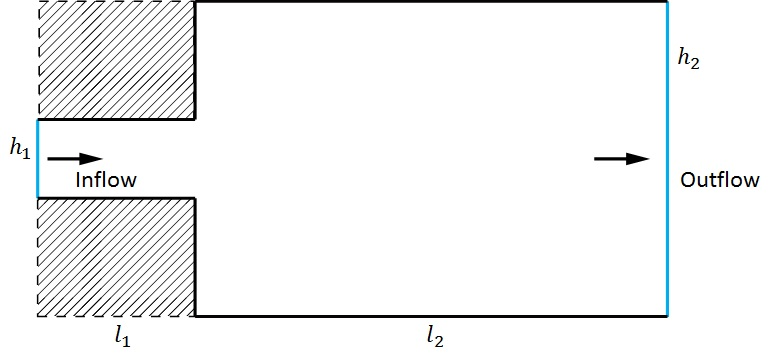

In [50]:
from IPython.display import Image
Image(filename=('D:\Dropbox\Study\Numerical methods for advanced fluids dynamics\Assignments\Assignment 1\system diagram.JPG'))

# The geometry
The above diagram illustrates the geometry of the tubes. The blue lines indicates inflow and outflow boundary, black lines indicate walls. To avoid complexity, the mesh generated in our calculation is still a square mesh and to account for the tube's geometry, the dashed area will not be involved in the calculation. The values of $u$, $v$ and $p$ in these regions are set to $0$ throughout the simulation

# Domain's equation
The problem is solved using Navier-Stokes equation:

$$
\begin{equation*}
\frac{\partial \mathbf{u} }{\partial t}+\mathbf{u}\cdot\nabla\mathbf{u}=-\frac{1}{\rho}\nabla p+\nu\nabla^{2}\mathbf{u}
\tag{1}\end{equation*}
$$

together with the continuity equation:

$$
\begin{equation*}
\nabla\cdot u=0
\tag{2}\end{equation*}
$$

where $\rho$ and $\nu$ is the fluid's density and viscousity, respectively, $\mathbf{u}$ represents the flow velocity and $p$ represents the pressure. This set of equations have a derivative forms:

$$
\begin{equation*}
\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = \frac{\rho_0}{\Delta t}\left(\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}\right)  -\rho_0\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right)
\tag{3}\end{equation*}
$$

$$
\begin{equation*}
\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y} =-\frac{1}{\rho_0}\frac{\partial p}{\partial x}+\nu \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right)
\tag{4}\end{equation*}
$$

$$
\begin{equation*}
\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y} = -\frac{1}{\rho_0}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right)
\tag{5}\end{equation*}
$$

Equation (3) is solved by using Successive Over Relaxation (SOR) method and results in $p$, which is subsequently plugged in equation (4) and (5) to solve for $u$ and $v$

# Boundary conditions

**1. At walls **

No-slip boundary condition is applied at every wall:
$$
\begin{equation*}
u=0, v=0
\tag{6}\end{equation*}
$$
As for pressure, at horizontal wall:
$$
\begin{equation*}
\frac{\partial p}{\partial y}=\rho\nu\frac{\partial^{2}v}{\partial y^{2}}
\tag{7}\end{equation*}
$$
and at vertical wall:
$$
\begin{equation*}
\frac{\partial p}{\partial x}=\rho\nu\frac{\partial^{2}u}{\partial x^{2}}
\tag{8}\end{equation*}
$$

** 2. At inflow and outflow **

For the inflow, the fluid velocity is set as:
$$
\begin{equation*}
u=u_{0}, v=0
\tag{9}\end{equation*}
$$
The boundary condition for the pressure is determined through the equation:
$$
\begin{equation*}
\mathbf{n}\cdot\nabla p =\rho \mathbf{n} \cdot \left(-\frac{\partial \mathbf{u}}{\partial t} - \mathbf{u} \cdot \nabla \mathbf{u}+\nu \nabla^{2}\mathbf{u} \right)
\tag{10}\end{equation*}
$$

which, due to the velocity's boundary conditions, will also becomes:
$$
\begin{equation*}
\frac{\partial p}{\partial x}=\rho\nu\frac{\partial^{2}u}{\partial x^{2}}
\tag{11}\end{equation*}
$$

For the outflow, the continuous condition is applied for velocity:
$$
\begin{equation*}
\frac{\partial u}{\partial x}=0, \frac{\partial v}{\partial x}=0
\tag{12}\end{equation*}
$$
The condition for outflow pressure is $p=0$ assuming that the flow has come to a stable state at the output.

Due to differences in boundary's conditions, two pressure solvers and two fluid flow solvers are needed, one for the forward flow (* **solvepres1*** and ***fluidflow1***) and one for the backward flow (***solvepres2*** and ***fluidflow2***)

In [51]:
#Pressure solver for forward flow
def solvepres1(p,dx,dy,rho):
    pn = np.empty_like(p)
    pn = p.copy()
    b = np.zeros((ny, nx))
    alpha=1.2
    
    b[1:-1,1:-1]=rho*(1/dt*((u[1:-1,2:]-u[1:-1,0:-2])/(2*dx)+(v[2:,1:-1]-v[0:-2,1:-1])/(2*dy))-\
        ((u[1:-1,2:]-u[1:-1,0:-2])/(2*dx))**2-\
        2*((u[2:,1:-1]-u[0:-2,1:-1])/(2*dy)*(v[1:-1,2:]-v[1:-1,0:-2])/(2*dx))-\
        ((v[2:,1:-1]-v[0:-2,1:-1])/(2*dy))**2)
    
    for q in range(nit):
        p[1:-1,1:-1]=(1-alpha)*pn[1:-1,1:-1]+\
                      alpha/(2*(dx**2+dy**2))*((pn[2:,1:-1]+p[0:-2,1:-1])*dy**2+(pn[1:-1,2:]+p[1:-1,0:-2])*dx**2-\
                                             b[1:-1,1:-1]*(dx**2*dy**2))
    
        
        
    # Neumann boundary conditions applied at all walls and at the inlet, Dirichlet boundary condition is applied at the outlet
        #Upper wall:
        p[-1,:] = p[-2,:]-rho*nu/dy*(-2*v[-2,:]+v[-3,:]) 
        
        #Lower wall:
        p[0,:] = p[1,:]-rho*nu/dy*(-2*v[1,:]+v[2,:])
        
        #Inlet:
        p[:,0] = p[:,1]-rho*nu/dx*(-2*u[:,1]+u[:,2])
        
        #Outlet:
        p[:,-1] = 0   
        
        #Lower wall of small tube
        p[(h2-h1)/(2*dy),0:(l1/dx)]=p[(h2-h1)/(2*dy)+1,0:(l1/dx)]-rho*nu/dy*(-2*v[(h2-h1)/(2*dy)+1,0:(l1/dx)]+v[(h2-h1)/(2*dy)+2,0:(l1/dx)])  
        
        #Upper wall of small tube
        p[(h2+h1)/(2*dy),0:(l1/dx)]=p[(h2+h1)/(2*dy)-1,0:(l1/dx)]-rho*nu/dy*(-2*v[(h2+h1)/(2*dy)-1,0:(l1/dx)]+v[(h2+h1)/(2*dy)-2,0:(l1/dx)])  
        
        #Lower wall of big tube
        p[0,:] = p[1,:] - rho*nu/dy*(-2*v[1,:]+v[2,:])
        
        #Upper wall of big tube
        p[-1,:] =p[-2,:]-rho*nu/dy*(-2*v[-2,:]+v[-3,:])
        
        
        #Lower vertical wall
        p[0:(h2-h1)/(2*dy),(l1/dx)]=p[0:(h2-h1)/(2*dy),(l1/dx)+1]-rho*nu/dx*(-2*u[0:(h2-h1)/(2*dy),(l1/dx)+1]+u[0:(h2-h1)/(2*dy),(l1/dx)+2])  
        
        #Upper vertical wall
        p[(h2+h1)/(2*dy):,(l1/dx)]=p[(h2+h1)/(2*dy):,(l1/dx)+1]-rho*nu/dx*(-2*u[(h2+h1)/(2*dy):,(l1/dx)+1]+u[(h2+h1)/(2*dy):,(l1/dx)+2]) 
        
    # Zero pressure at the domain outside the geometry
        p[0:(h2-h1)/(2*dy),0:(l1/dx)-1]=0
        p[(h2+h1)/(2*dy)+1:ny,0:(l1/dx)-1]=0
        
        
        
    return p


In [52]:
#Pressure solver for backward flow
def solvepres2(p,dx,dy,rho):
    pn = np.empty_like(p)
    pn = p.copy()
    b = np.zeros((ny, nx))
    alpha=1.2
    
    b[1:-1,1:-1]=rho*(1/dt*((u[1:-1,2:]-u[1:-1,0:-2])/(2*dx)+(v[2:,1:-1]-v[0:-2,1:-1])/(2*dy))-\
        ((u[1:-1,2:]-u[1:-1,0:-2])/(2*dx))**2-\
        2*((u[2:,1:-1]-u[0:-2,1:-1])/(2*dy)*(v[1:-1,2:]-v[1:-1,0:-2])/(2*dx))-\
        ((v[2:,1:-1]-v[0:-2,1:-1])/(2*dy))**2)
    
    for q in range(nit):
        p[1:-1,1:-1]=(1-alpha)*pn[1:-1,1:-1]+\
                      alpha/(2*(dx**2+dy**2))*((pn[2:,1:-1]+p[0:-2,1:-1])*dy**2+(pn[1:-1,2:]+p[1:-1,0:-2])*dx**2-\
                                             b[1:-1,1:-1]*(dx**2*dy**2))
    
        
        
    # Neumann boundary conditions applied at all walls and at the inlet
        #Upper wall:
        p[-1,:] = p[-2,:]-rho*nu/dy*(-2*v[-2,:]+v[-3,:]) 
        
        #Lower wall:
        p[0,:] = p[1,:]-rho*nu/dy*(-2*v[1,:]+v[2,:])
        
        #Outlet:
        p[:,0] = 0
        
        #Inlet:
        p[:,-1] = p[:,-2]-rho*nu/dy*(-2*v[:,-2]+v[:,-3])
        
        #Lower wall of small tube
        p[(h2-h1)/(2*dy),0:(l1/dx)]=p[(h2-h1)/(2*dy)+1,0:(l1/dx)]-rho*nu/dy*(-2*v[(h2-h1)/(2*dy)+1,0:(l1/dx)]+v[(h2-h1)/(2*dy)+2,0:(l1/dx)])  
        
        #Upper wall of small tube
        p[(h2+h1)/(2*dy),0:(l1/dx)]=p[(h2+h1)/(2*dy)-1,0:(l1/dx)]-rho*nu/dy*(-2*v[(h2+h1)/(2*dy)-1,0:(l1/dx)]+v[(h2+h1)/(2*dy)-2,0:(l1/dx)])  
        
        #Lower wall of big tube
        p[0,:] = p[1,:] - rho*nu/dy*(-2*v[1,:]+v[2,:])
        
        #Upper wall of big tube
        p[-1,:] =p[-2,:]-rho*nu/dy*(-2*v[-2,:]+v[-3,:])
        
        
        #Lower vertical wall
        p[0:(h2-h1)/(2*dy),(l1/dx)]=p[0:(h2-h1)/(2*dy),(l1/dx)+1]-rho*nu/dx*(-2*u[0:(h2-h1)/(2*dy),(l1/dx)+1]+u[0:(h2-h1)/(2*dy),(l1/dx)+2])  
        
        #Upper vertical wall
        p[(h2+h1)/(2*dy):,(l1/dx)]=p[(h2+h1)/(2*dy):,(l1/dx)+1]-rho*nu/dx*(-2*u[(h2+h1)/(2*dy):,(l1/dx)+1]+u[(h2+h1)/(2*dy):,(l1/dx)+2]) 
        
    # Zero pressure at the domain outside the geometry
        p[0:(h2-h1)/(2*dy)-1,0:(l1/dx)-1]=0
        p[(h2+h1)/(2*dy)+1:ny,0:(l1/dx)-1]=0
        
        
        
    return p

In [53]:
#The function where the fluid flows from the small tube towards the big tube
def fluidflow1(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        p = solvepres1(p, dx, dy, rho)
        
        u[1:-1,1:-1] = un[1:-1,1:-1]-\
                        un[1:-1,1:-1]*dt/dx*(un[1:-1,1:-1]-un[1:-1,0:-2])-\
                        vn[1:-1,1:-1]*dt/dy*(un[1:-1,1:-1]-un[0:-2,1:-1])-\
                        dt/(2*rho*dx)*(p[1:-1,2:]-p[1:-1,0:-2])+\
                        nu*(dt/dx**2*(un[1:-1,2:]-2*un[1:-1,1:-1]+un[1:-1,0:-2])+\
                        dt/dy**2*(un[2:,1:-1]-2*un[1:-1,1:-1]+un[0:-2,1:-1]))

        v[1:-1,1:-1] = vn[1:-1,1:-1]-\
                        un[1:-1,1:-1]*dt/dx*(vn[1:-1,1:-1]-vn[1:-1,0:-2])-\
                        vn[1:-1,1:-1]*dt/dy*(vn[1:-1,1:-1]-vn[0:-2,1:-1])-\
                        dt/(2*rho*dy)*(p[2:,1:-1]-p[0:-2,1:-1])+\
                        nu*(dt/dx**2*(vn[1:-1,2:]-2*vn[1:-1,1:-1]+vn[1:-1,0:-2])+\
                        (dt/dy**2*(vn[2:,1:-1]-2*vn[1:-1,1:-1]+vn[0:-2,1:-1])))

        
        # Define boundary condition for velocity
        
        u[:,0] = u0 # The inflow
        u[:,-1] = u[:,-2] #  The outflow
        u[0,:] = 0
        u[-1,:] = 0    
        v[0,:] = 0
        v[-1,:]=0
        v[:,0] = 0
        v[:,-1] = v[:,-2]  #  The outflow
        
        # Zero velocity at the domain outside the geometry

        v[0:(h2-h1)/(2*dy)+1,0:(l1/dx)+1]=0
        v[(h2+h1)/(2*dy):ny,0:(l1/dx)+1]=0
        u[0:(h2-h1)/(2*dy)+1,0:(l1/dx)+1]=0
        u[(h2+h1)/(2*dy):ny,0:(l1/dx)+1]=0
        
    
        
    return u, v, p

In [54]:
#The function where the fluid flows from the big tube towards the small tube
def fluidflow2(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        p = solvepres2(p, dx, dy, rho)
        
        u[1:-1,1:-1] = un[1:-1,1:-1]-\
                        un[1:-1,1:-1]*dt/dx*(un[1:-1,1:-1]-un[1:-1,0:-2])-\
                        vn[1:-1,1:-1]*dt/dy*(un[1:-1,1:-1]-un[0:-2,1:-1])-\
                        dt/(2*rho*dx)*(p[1:-1,2:]-p[1:-1,0:-2])+\
                        nu*(dt/dx**2*(un[1:-1,2:]-2*un[1:-1,1:-1]+un[1:-1,0:-2])+\
                        dt/dy**2*(un[2:,1:-1]-2*un[1:-1,1:-1]+un[0:-2,1:-1]))

        v[1:-1,1:-1] = vn[1:-1,1:-1]-\
                        un[1:-1,1:-1]*dt/dx*(vn[1:-1,1:-1]-vn[1:-1,0:-2])-\
                        vn[1:-1,1:-1]*dt/dy*(vn[1:-1,1:-1]-vn[0:-2,1:-1])-\
                        dt/(2*rho*dy)*(p[2:,1:-1]-p[0:-2,1:-1])+\
                        nu*(dt/dx**2*(vn[1:-1,2:]-2*vn[1:-1,1:-1]+vn[1:-1,0:-2])+\
                        (dt/dy**2*(vn[2:,1:-1]-2*vn[1:-1,1:-1]+vn[0:-2,1:-1])))

        
        # Define boundary condition for velocity
        
        u[:,0]=u[:,1] #The outflow
        u[:,-1] = -u0  # The inflow
        u[0,:] = 0
        u[-1,:] = 0    
        v[0,:] = 0
        v[-1,:]=0
        v[:,0] = v[:,1]  # The outflow
        v[:,-1] = 0
        
        # Zero velocity at the domain outside the geometry

        v[0:(h2-h1)/(2*dy)+1,0:(l1/dx)+1]=0
        v[(h2+h1)/(2*dy):ny,0:(l1/dx)+1]=0
        u[0:(h2-h1)/(2*dy)+1,0:(l1/dx)+1]=0
        u[(h2+h1)/(2*dy):ny,0:(l1/dx)+1]=0
        
    
        
    return u, v, p

In [55]:
def makegraph(name,k):
    Q=plt.quiver(X[::4,::4],Y[::4,::4],u[::4,::4],v[::4,::4],scale=k)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('%s' %(name))
    a=plt.gca()
    r1=a.add_patch(Rectangle((0,0),l1,(h2-h1)/2,facecolor="white"))
    r2=a.add_patch(Rectangle((0,(h1+h2)/2),l1,(h2-h1)/2,facecolor="white"))

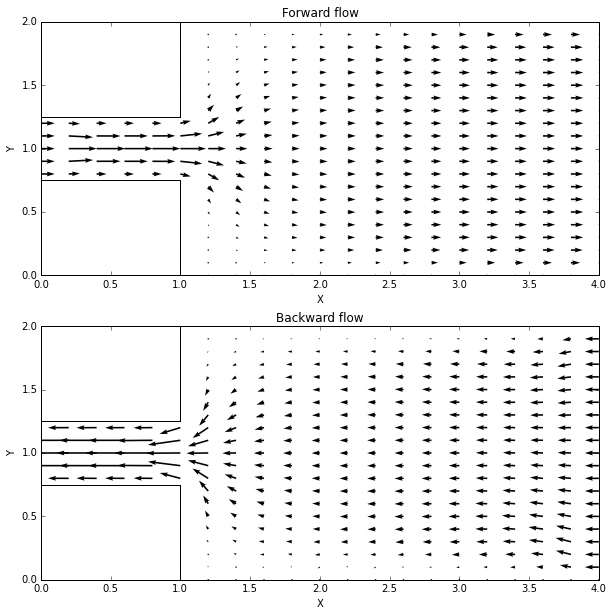

In [56]:
#Setup the geometry and grid system
h1=0.5
h2=2.
l1=1.
l2=3.
nx=81
ny=81
dx=(l1+l2)/(nx-1)
dy=h2/(ny-1)
x= np.linspace(0,(l1+l2),nx)
y= np.linspace(0,h2,ny)
X,Y=np.meshgrid(x,y)
nit=100
nt=200

#Setup input parameter for the system
rho=1.
nu=0.1
dt=0.001
u0=0.01
Re=u0*(l1+l2)/(nu)

#Initialize the system
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 

fig=plt.figure(figsize=(10,10), dpi=100)

# Solve the problem of the forward flow
ax=fig.add_subplot(211)
u,v,p=fluidflow1(nt, u, v, dt, dx, dy, p, rho, nu)
makegraph('Forward flow',0.4)

#Re initialize the system
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))

# Solve the problem of the backward flow
ax=fig.add_subplot(212)
u,v,p=fluidflow2(nt, u, v, dt, dx, dy, p, rho, nu)
makegraph('Backward flow',0.4)


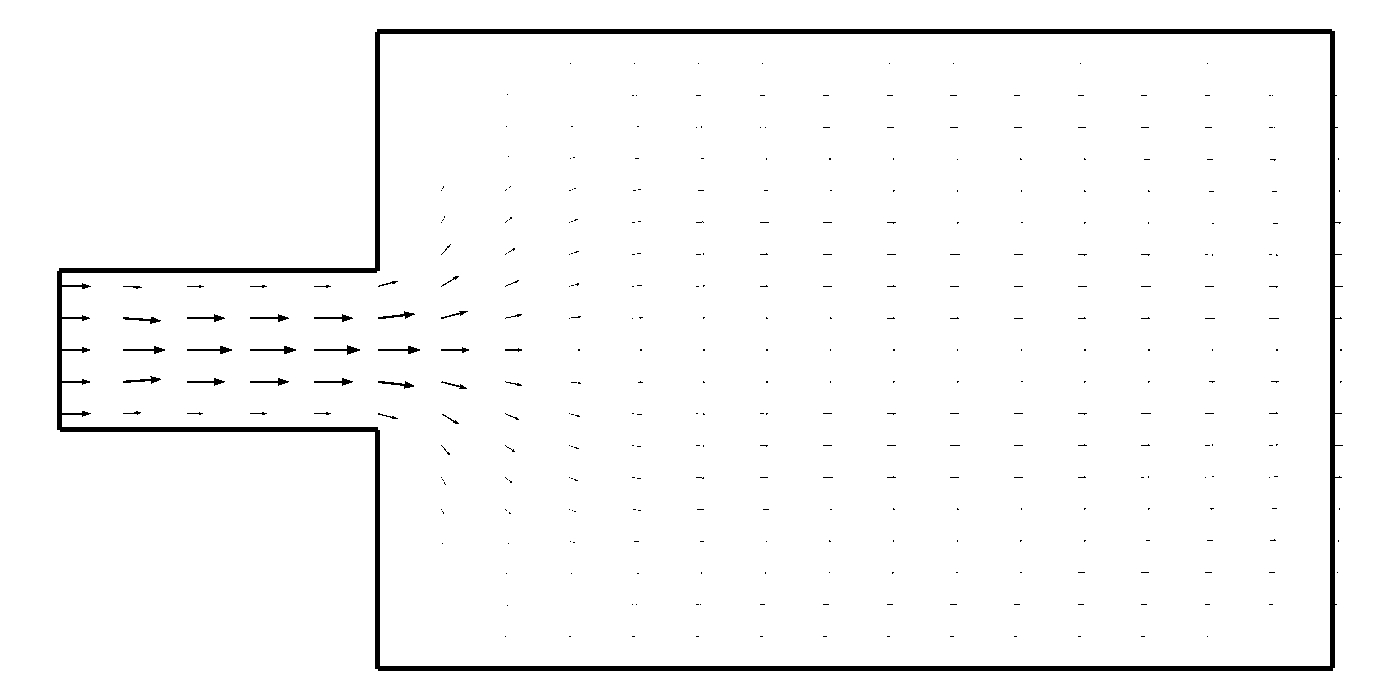

In [62]:
# Comsol simulation of the forward flow
from IPython.display import Image
Image(filename=('D:\Dropbox\Study\Numerical methods for advanced fluids dynamics\Assignments\Assignment 1\Comsol forward flow.JPG'))

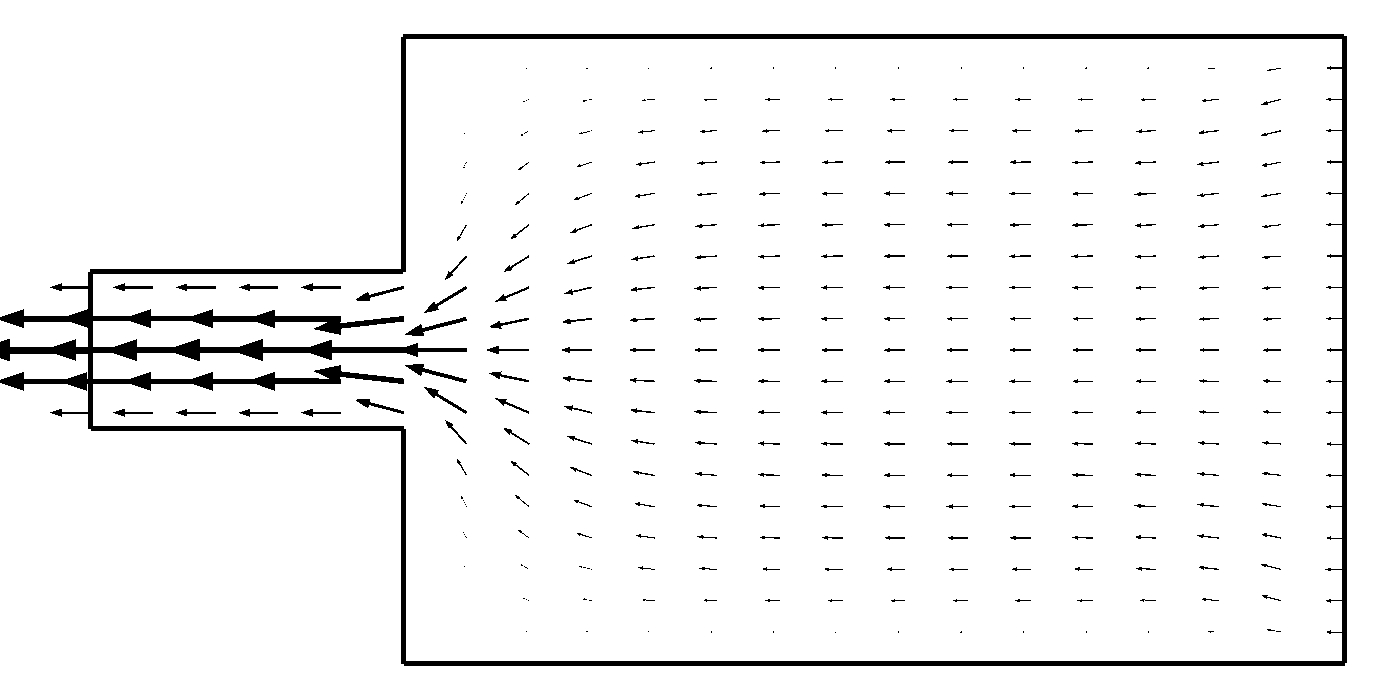

In [63]:
# Comsol simulation of the backward flow
from IPython.display import Image
Image(filename=('D:\Dropbox\Study\Numerical methods for advanced fluids dynamics\Assignments\Assignment 1\Comsol backward flow.JPG'))


The two top figures illustrates the flow field after 0.2 seconds in the case of forward flow and backward flow, respectively. The two bottom figures are simulation result of the same problem from Comsol Multiphysics. It can be seen that neglecting the visual differences caused by the boldness of the arrows (which is not important since only the length of the arrow represents flow's velocity), the fluid's behavior described by the two methods match very well with each other, which shows the validity of our result.

Now we progress to solving the problem with different Reynold number, which is expressed as:
$$
Re=\frac{uL}{\nu}
$$

Reynold number can be varied by changing either velocity $u$, system size $l$ or viscousity $\nu$. Here we choose velocity $u$ as the varying parameter.

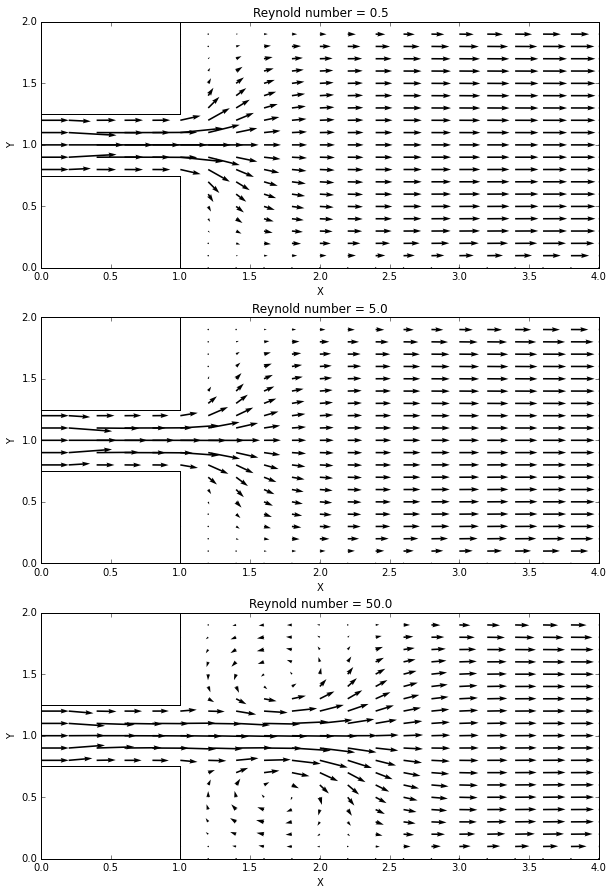

In [59]:
fig=plt.figure(figsize=(10,15), dpi=100)
u0=0.01
nu=0.1

#Small Reynold number:
u0=0.1
Re=u0*h1/(nu)

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
u,v,p=fluidflow1(nt, u, v, dt, dx, dy, p, rho, nu)

ax=fig.add_subplot(311)
makegraph('Reynold number = %s'%(Re),2.0)

#Average Reynold number:
u0=1.0
Re=u0*h1/(nu)

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
u,v,p=fluidflow1(nt, u, v, dt, dx, dy, p, rho, nu)

ax=fig.add_subplot(312)
makegraph('Reynold number = %s'%(Re),20.0)

#Big Reynold number:
u0=10.0
Re=u0*h1/(nu)

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
u,v,p=fluidflow1(nt, u, v, dt, dx, dy, p, rho, nu)

ax=fig.add_subplot(313)
makegraph('Reynold number = %s'%(Re),200.0)


When $Re=0.5$ and $Re=5.0$, the fluid experience a smooth, stable flow, similarly to what described in the previous part of the note. However, as $Re$ approach $50$, there is a significant change in the flow pattern. The reason is that at high Reynold number, viscous forces are no longer dominant, causing the flow to change from a laminar flow to a turbulent flow. This leads to formation of vortices as can be seen in the last figure. Laminar flow is still observed at the output because in our code, we still keep the outflow pressure to be 0 with the assumption of a stable flow. This assumption is not valid for high Reynold number.